## CS410 Fall 2022 Team project - Flagging COVID Disinformation - Notebook B
Team members: David Burrus, Ginna Woo, Jianci Zhai
### Summary: 
As proposed, this project aspired to produce a browser extension that marks up COVID-related search results with an "information accuracy" score ranging from 1 (likely disinformation) to 5 (likely accurate informational). The team divided the work into three subprojects: (1) scraping search engine results to feed into a classification model, (2) the classification model itself, and (3) a user interface to display the "disinfo/info score".

This Jupyter notebook focuses on items (2) and (3). A separate Jupyter notebook, also submitted as part of this project, focuses on items (1) and (2). Correctly classifying disinformation or so-called "fake news" remains a challenging problem, even for the most experienced researchers. The project team therefore investigated multiple classification methods in parallel. Notebook A implements a discriminative model (Support Vector Machine). Notebook B (this one) implements LDA (Latent Dirichlet Allocation) clustering in combination with logistic regression.

This notebook also implements an interactive user interface, in lieu of a full browser extension (which proved impossible to implement within the time constraints of an introductory class project). When this notebook is executed, a dialog box will prompt the user to enter (a) a COVID-related web site address and (b) the text contents of that address. The LDA classifier in this notebook then will attempt to determine if the web site is more likely to contain accurate information or disinformation. The program's output will be displayed below, in this notebook -- not in the dialog box.

How the code works is documented in separate markdown blocks, below.

## Part I - Initialization and User Interface
The code in Part I is self-contained and stand-alone with a dialog box for data entry.

Part II contains nearly the same code as Part I, without the GUI dialog box. Part II code is divided into many separate code blocks, so that a reviewer may step through it more easily and see how the code works.

Part III contains code written to identify the optimal number of LDA clusters. Part III should be run only after running Part II.

In [96]:
# Python libraries for dataframe and math functions
import numpy as np
import pandas as pd

# library to read and write Excel files containing reference data for classifier
import openpyxl
from openpyxl import Workbook

# library to create dialog box
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import sys
import subprocess

# libraries for text processing and analysis
import nltk
nltk.download('vader_lexicon',quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# initialize variables required by Tkinter
linkValue = StringVar
wordValue = StringVar
submitValue = IntVar

class GUI:

    # function to initialize and manage the dialog box interface
    def __init__(self,screen):
        # initialize dialog box
        self.screen = screen
        self.screen.geometry('750x250')
        # set title and instruction text
        self.screen.title('Disinformation Analysis')
        Label(screen,text="Disinformation Analysis",font="ar 15 bold").grid(row=0,column=2)
        Label(screen,text="Please enter link and the site's content below! Click Submit Analysis to start analysis.",
              font="ar 10 bold").grid(row=1,column=2)
        Label(screen,
              text="Link example: https://www.mountsinai.org/health-library/special-topic/how-to-stop-the-spread-of-covid-19.",
              font="ar 8 italic",wraplength=600).grid(row=2,column=2)
        Label(screen,
              text="Link content example: Coronavirus disease 2019 (COVID-19) is a serious disease, mainly of the respiratory system, affecting many people around the"
                   " globe. It can cause mild to severe illness and even death. COVID-19 spreads easily between people. Learn how to protect yourself and others from this illness..",
              font="ar 8 italic",wraplength=500).grid(row=3,column=2)
        # create labels for the two entry fields
        link = Label(screen,text="Enter a link")
        word = Label(screen,text="Paste the entire link's content")
        # position labels
        link.grid(row=4,column=1)
        word.grid(row=5,column=1)
        # create text entry fields for web site URL and contents
        self.linkEntry = Entry(screen,textvariable=linkValue,width=40)
        self.wordEntry = Entry(screen,textvariable=wordValue,width=40)
        # position text entry fields
        self.linkEntry.grid(row=4,column=2)
        self.wordEntry.grid(row=5,column=2)
        # create buttons for user submission and program exit
        submit = Button(screen,command=self.check_function,cursor="hand2",text="Submit Analysis")
        exit = Button(screen,command=self.exit_application,cursor="hand2",text="Exit")
        submit.grid(row=6,column=2)
        exit.grid(row=6,column=3,pady=20)
        
        
    # evaluate the user's input with a classifier based on reference data 
    def check_function(self):
        # grab user entries from link and content fields
        url = self.linkEntry.get()
        url_content = self.wordEntry.get()
        # echo user entries to standard output below
        print("Link entered: \n",url)
        print("Content entered: \n",url_content[0:200])
        
        # read in COVID reference data that is used to construct the classifier
        # covid_search_results_summary.xls can be considered to represent search engine results.
        # The Excel file includes these columns for 242 web pages that were returned by COVID-related queries: 
        # 'link' = the URL for each search engine result
        # 'content' = text from that search engine result page
        # 'given_by_user1' = an initial judgment of disinformation likelihoos from one team member
        df = pd.read_excel('covid_search_results_summary.xls').dropna()
        print('STEP 1: Ingesting the file')
        
        # rename dataframe columns to mark the "original" (org) reference data
        df.columns = df.columns.str.lower().str.replace(' ','_') + '_org'
        org_len = len(df)
        df.loc[org_len] = [org_len + 1,url_content,url,0,len(url_content)]
        
        # extract the host (domain name + top-level domain from the URL entered by the user
        import tldextract
        df['link_clean'] = df['link_org'].apply(lambda x: tldextract.extract(x)[2])
        df['host'] = df['link_org'].apply(lambda x: tldextract.extract(x)[1]+"."+tldextract.extract(x)[2])
        
        # compare the host to a list of more than 3,400 domains that have been evaluated for information accuracy
        # by independent and transparent fact-checking organizations. 
        url_ref = pd.read_excel('url_accuracy.xls').dropna()
        df = pd.merge(df, url_ref, how = 'left')
        df['accuracy_score'] = df['accuracy_score'].fillna(3)
        def categorise(row):  
            if row['accuracy_score'] == 1:
                return 1
            elif row['accuracy_score'] == 5:
                return 5
            else:
                return row['given_by_user1_org']
        df['judgement_score'] = df.apply(lambda row: categorise(row), axis=1)

        # add dataframe columns for sentiment analysis 
        df['polarity_scores'] = df['content_org'].apply(sia.polarity_scores)
        df['sentiment_neg'] = df['polarity_scores'].apply(lambda x: x['neg'])
        df['sentiment_neu'] = df['polarity_scores'].apply(lambda x: x['neu'])
        df['sentiment_pos'] = df['polarity_scores'].apply(lambda x: x['pos'])
        df['sentiment_compound'] = df['polarity_scores'].apply(lambda x: x['compound'])

        # remove stopwords, punctuation, and numbers from the reference content
        nltk.download('punkt',quiet=True)
        text1 = df['content_org']
        text2 = [remove_stopwords(x) \
                     .translate(str.maketrans('','',string.punctuation)) \
                     .translate(str.maketrans('','',string.digits)) \
                 for x in text1]
        
        # perform stemming on the reference content
        def stemSentence(sentence):
            porter = PorterStemmer()
            token_words = word_tokenize(sentence)
            stem_sentence = [porter.stem(word) for word in token_words]
            return ' '.join(stem_sentence)
        
        print('STEP 2: Tokenization')
        text3 = pd.Series([stemSentence(x) for x in text2])

        # remove non-ascii characters and perform TF-IDF vectorization at the word level
        vectorizer_wtf = TfidfVectorizer(analyzer='word',strip_accents="ascii")  # strip_accent: remove non-English
        X_wtf = vectorizer_wtf.fit_transform(text3)
        content_tfidf = pd.DataFrame(X_wtf.toarray())
        content_tfidf.columns = vectorizer_wtf.get_feature_names_out()
        # To improve the computation efficiency, remove words that the overall normalized values show are too small 
        # to have a serious impact on the results (value <= 25% percentile) 
        token_weight_normalized = content_tfidf.sum(axis=0,skipna=True)
        low_bound = 0.02  # (around 25%)
        token_weight_normalized = token_weight_normalized[token_weight_normalized >= low_bound]
        content_tfidf_filtered = content_tfidf[token_weight_normalized.index]
        
        print('STEP 3: TF-IDF Transformation')
        n_cnt = 11  # variable for optimal topic count, as determined through analysis in Part III
        lda = LatentDirichletAllocation(n_components=n_cnt,learning_decay=0.9,random_state=35)
        X_lda = lda.fit(content_tfidf_filtered)

        # Commented out IPython magic to ensure Python compatibility.
        from matplotlib import pyplot as plt
        # %matplotlib inline
        import plotly.express as px

        def plot_top_words(model,feature_names,n_top_words,title):
            fig,axes = plt.subplots(4,3,figsize=(30,30),sharex=True)
            axes = axes.flatten()
            for topic_idx,topic in enumerate(model.components_):
                top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
                top_features = [feature_names[i] for i in top_features_ind]
                weights = topic[top_features_ind]

                ax = axes[topic_idx]
                ax.barh(top_features,weights,height=0.7)
                ax.set_title(f'Topic {topic_idx + 1}',
                             fontdict={'fontsize': 30})
                ax.invert_yaxis()
                ax.tick_params(axis='both',which='major',labelsize=20)
                for i in 'top right left'.split():
                    ax.spines[i].set_visible(False)
                fig.suptitle(title,fontsize=40)
            plt.subplots_adjust(top=0.90,bottom=0.05,wspace=0.90,hspace=0.3)
            plt.show()

        # create LDA score by document by topic
        feature_names = content_tfidf_filtered.columns
        lda_score_by_topic = pd.DataFrame(X_lda.components_.dot(content_tfidf_filtered.T).T)
        
        print('STEP 4: LDA Clustering')
        lst_n_cnt = list(range(1,n_cnt + 1))
        topic_n_cnt = ['topic_' + str(i) for i in lst_n_cnt]
        lda_score_by_topic.columns = topic_n_cnt
        df_normalized = pd.concat([df,content_tfidf_filtered,lda_score_by_topic],axis=1)
        df_normalized['y_misinfo_tag'] = np.where(df_normalized['judgement_score'] <= 3,1,0)
        df_normalized['len_log'] = np.log10(df_normalized['len_org']) / 10

        print('STEP 5: Prepare Modeling')
        from sklearn.linear_model import LogisticRegression
        from sklearn.model_selection import train_test_split

        df_mdl_prep = df_normalized[['y_misinfo_tag',
                                     'len_log',
                                     'accuracy_score',
                                     'sentiment_neg',
                                     'sentiment_neu',
                                     'sentiment_pos',
                                     ] + topic_n_cnt]
        
        # set up training and testing data sets
        y_train = df_mdl_prep.iloc[:org_len,0].values
        x_train = df_mdl_prep.iloc[:org_len,1:len(df_mdl_prep)].values
        x_test = df_mdl_prep.iloc[org_len:org_len + 1,1:len(df_mdl_prep)].values
        # fit the logistic regression classifier to the training data set
        classifier = LogisticRegression(random_state=1)
        classifier.fit(x_train,y_train)
        # convert logistic regression output to 5-point scale from 1 (disinfo) to 5 (accurate info)
        y_pred = float(classifier.predict_proba(x_test)[:,1][0])
        if y_pred <= 0.2:
            output_label = '5 Probably Accurate'
        elif y_pred <= 0.4:
            output_label = '4 Possibly Accurate'
        elif y_pred <= 0.6:
            output_label = '3 Neutral or Mixed Info/Disinfo'
        elif y_pred <= 0.8:
            output_label = '2 Possibly Disinformation'
        else:
            output_label = '1 Probably Disinformation'
        output_label
        
        if url == "" or url_content == "":
            messagebox.showerror("ERROR","Please try another link.",parent=self.screen)
        else:
            print("Disinformation analysis score for: \n", output_label)

    # Close program when Exit button is clicked
    def exit_application(self):
        screen.destroy()


# main program
screen = Tk()
obj = GUI(screen)
screen.mainloop()

Link entered: 
 https://www.who.int/westernpacific/emergencies/covid-19/information/asymptomatic-covid-19

Content entered: 
 Asymptomatic COVID-19 - A person infected with COVID-19 also may not experience any symptoms and, without knowing, can transmit the virus to others. Get vaccinated and keep up all the protective measu
STEP 1: Ingesting the file
STEP 2: Tokenization
STEP 3: TF-IDF Transformation
STEP 4: LDA Clustering
STEP 5: Prepare Modeling
Disinformation analysis score for: 
 5 Probably Accurate
Link entered: 
 https://www.bloomberg.com/news/articles/2021-08-27/previous-covid-prevents-delta-infection-better-than-pfizer-shot
Content entered: 
 People who recovered from a bout of Covid-19 during one of the earlier waves of the pandemic appear to have a lower risk of contracting the delta variant than those who got two doses of the vaccine fr
STEP 1: Ingesting the file
STEP 2: Tokenization
STEP 3: TF-IDF Transformation
STEP 4: LDA Clustering
STEP 5: Prepare Modeling
Disinformatio

## Part II: Code Deep Dive
This section allows reviewers to run the code step by step and see the effects of each code block.
Provide detailed explanation of the functions and related theories of codes.
Also allow reviewers to test and debug the codes when necessary.
Reference resource: https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8

In [29]:
# input library
import numpy as np 
import pandas as pd
from collections import Counter #count token by doc
import re
import warnings
# warnings.filterwarnings('ignore')
import gensim

### Pre-processing

In [30]:
# read in COVID reference data that is used to construct the classifier
# covid_search_results_summary.xls can be considered to represent search engine results.
# The Excel file includes these columns for 242 web pages that were returned by COVID-related queries: 
# 'link' = the URL for each search engine result
# 'content' = text from that search engine result page
# 'given_by_user1' = an initial judgment of disinformation likelihoos from one team member
df = pd.read_excel('covid_search_results_summary.xls').dropna()

In [33]:
# Before running this block, please replace 'test.com' with an actual URL. 
# This is equivalent to the URL entry field in Part I.
url = 'test.com' 
url = 'https://twitter.com/CristianTerhes/status/1589262808084250624'

In [34]:
# Before running this block, please replace 'test content' with actual content from the URL in the preceding block. 
# This is equivalent to the page contents entry field in Part I.
url_content = 'test content' 
url_content = 'The new COVID bivalent boosters aren’t better than the old injections, a study finds. But these bivalent boosters were not tested in humans before they were approved in USA. So how really "safe and effective" are they? We need to demand answers to these questions. #TheyAllLied'

In [35]:
# rename dataframe columns to mark the "original" (org) reference data
df.columns=df.columns.str.lower().str.replace(' ','_')+'_org' #means original input

In [36]:
# show the renamed columns in the dataframe
df.columns

Index(['doc_id_org', 'content_org', 'link_org', 'given_by_user1_org',
       'len_org'],
      dtype='object')

In [37]:
#original row count of the file, and add new input at the very end as the testing data
org_len = len(df)

In [38]:
df.loc[org_len] = [org_len + 1, url_content, url, 0, len(url_content)]

In [39]:
# at the bottom there are dummy samples blended in to help avoid the algorithm 
# to discredit trustworthy resource due to small length 
df

,doc_id_org,content_org,link_org,given_by_user1_org,len_org
0,1,COVID Natural Immunity: What You Need to Know\...,https://www.hopkinsmedicine.org/health/conditi...,5,6530
1,2,Science Brief: SARS-CoV-2 Infection-induced an...,https://www.cdc.gov/coronavirus/2019-ncov/scie...,5,32767
2,3,Word of the Month: Long COVID\nMike Ybarra\nMi...,https://catalyst.phrma.org/word-of-the-month-w...,4,4683
3,4,Previous Covid Prevents Delta Infection Better...,https://www.bloomberg.com/news/articles/2021-0...,5,1469
4,5,IU School of Medicine researchers launch state...,https://medicine.iu.edu/news/2020/05/researche...,5,3227
...,...,...,...,...,...
232,233,President Trump hospitalized at Walter Reed af...,https://www.usatoday.com/story/news/politics/e...,5,8179
233,234,Do you believe covid is a complete hoax?\n362 ...,https://www.reddit.com/r/conspiracy/comments/j...,3,10997
234,235,COVID booster may lower protection against omi...,https://www.miamiherald.com/news/coronavirus/a...,4,6835
235,236,Health officials encourage COVID-19 booster as...,https://www.fox5ny.com/news/covid-19-bivalent-...,4,7697


##### Explanation:
In addition, we also expect the length of content, the sentiment tagging, and domains of the website will be great predictors for our model.

Our team member takes the extra milage to browse through websites that identifys trustworthy content, and use that information to tag our dataset. we believe it's very hard to rely purely on human to identify fake info due to among of data available online. so if there is very strong signal to ensure the content is trustworthy or not trustworthy (from [url_accuracy] with a score of 1 or 5, we will override human judgement with the info from the list

When the accuracy score can't provide a judgement or a judgement around 2-4 (not very certain), we will rely on human judgement.

In [40]:
# extract the host (domain name + top-level domain from the URL entered by the user
import tldextract
df['link_clean'] = df['link_org'].apply(lambda x: tldextract.extract(x)[2])
df['host'] = df['link_org'].apply(lambda x: tldextract.extract(x)[1]+"."+tldextract.extract(x)[2])

# compare the host to a list of more than 3,400 domains that have been evaluated for information accuracy
# by independent and transparent fact-checking organizations. 
# This list is able to match ~159 (65%) of the 242 rows in covid_search_results_summary.xls
url_ref = pd.read_excel('url_accuracy.xls').dropna()
df = pd.merge(df, url_ref, how = 'left')

# assign a 'neutral' rating (accuracy = 3) to any rows that could not be matched with expert judgments
df['accuracy_score'] = df['accuracy_score'].fillna(3)

# combine accuracy score and judgement of one team member
def categorise(row):  
    if row['accuracy_score'] == 1:
        return 1
    elif row['accuracy_score'] == 5:
        return 5
    else:
        return row['given_by_user1_org']
df['judgement_score'] = df.apply(lambda row: categorise(row), axis=1)

In [41]:
df[['judgement_score','given_by_user1_org','accuracy_score']]

,judgement_score,given_by_user1_org,accuracy_score
0,5,5,5.0
1,5,5,5.0
2,5,4,5.0
3,5,5,4.0
4,5,5,3.0
...,...,...,...
232,5,5,5.0
233,3,3,3.0
234,5,4,5.0
235,5,4,5.0


In [42]:
# add dataframe columns for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df['polarity_scores'] = df['content_org'].apply(sia.polarity_scores)
df['sentiment_neg'] = df['polarity_scores'].apply(lambda x: x['neg'])
df['sentiment_neu'] = df['polarity_scores'].apply(lambda x: x['neu'])
df['sentiment_pos'] = df['polarity_scores'].apply(lambda x: x['pos'])
df['sentiment_compound'] = df['polarity_scores'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
# Libraries for file tokenization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.model_selection import GridSearchCV 
from gensim.parsing.preprocessing import remove_stopwords 
import string 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

# Download once if using NLTK for preprocessing 
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Explanation
The code at a high level consists of tokenizing the data to remove punctuation, stop words, and numbers. The analysis is carried out using Natural Language Toolkit (NLTK), which is a popular API (application programming interfaces) for Natural Language Processing (NLP) in Python. NLTK is used for stemming (reduces the number of unique words by analyzing just the stem of a word), and lemmatization (uses context to determine the meaning of a word). We also remove non-English words from the results, and then perform a normalization of the datasets using tf-idf methods.

In [45]:
# remove stopwords, punctuation, and numbers from the reference content
import string
from gensim.parsing.preprocessing import remove_stopwords

text1= df['content_org']
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

In [46]:
# perform stemming on the reference content
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)
text3 = pd.Series([stemSentence(x) for x in text2])

In [47]:
# remove non-ascii characters and perform TF-IDF vectorization at the word level
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

vectorizer_wtf = TfidfVectorizer(analyzer='word',strip_accents = "ascii") #strip_accent: remove non-English
X_wtf = vectorizer_wtf.fit_transform(text3)

In [48]:
vectorizer_wtf.get_feature_names_out()

array(['12year', 'aaf', 'aapi', ..., 'zuckerberg', 'zxc', 'zz'],
      dtype=object)

In [49]:
content_tfidf = pd.DataFrame(X_wtf.toarray())

In [50]:
content_tfidf.columns = vectorizer_wtf.get_feature_names_out()

In [51]:
# To improve the computation efficiency, remove words that the overall normalized values show are too small 
# to have a serious impact on the results (value <= 25% percentile) 
token_weight_normalized = content_tfidf.sum(axis=0, skipna=True)

In [52]:
token_weight_normalized.index

Index(['12year', 'aaf', 'aapi', 'aarhu', 'aaron', 'aarup', 'ab', 'aback',
       'abandon', 'abbasi',
       ...
       'zone', 'zoo', 'zoom', 'zoonos', 'zoonot', 'zte', 'zubkov',
       'zuckerberg', 'zxc', 'zz'],
      dtype='object', length=14914)

In [53]:
token_weight_normalized.describe()

count    14914.000000
mean         0.186349
std          0.480108
min          0.004410
25%          0.021818
50%          0.049861
75%          0.144803
max         18.531524
dtype: float64

In [54]:
# set the cut-off point 
low_bound = 0.02 #(around 25%)

In [55]:
token_weight_normalized = token_weight_normalized[token_weight_normalized>= low_bound]

In [56]:
content_tfidf_filtered = content_tfidf[token_weight_normalized.index]

In [57]:
content_tfidf_filtered

,12year,aaf,aapi,aaron,ab,aback,abandon,abbasi,abbott,abbvi,...,zombi,zone,zoo,zoom,zoonot,zte,zubkov,zuckerberg,zxc,zz
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.008526,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LDA Clustering
There are many ways to vectorization, or combine features (normalized word weight). Based on our course, there is really no method proves to be the best. We choose LDA for two reasons: 
1. we never use it before among the programming assignments; and 
2. unlike k-means/tree-based algorithm, LDA is very specific to use in NLP.

In [58]:
# set variable for topic count. The value of 11 was chosen based on algorithm optmization done in Part III
n_cnt = 11 
lda = LatentDirichletAllocation(n_components=n_cnt , learning_decay=0.9, random_state=35)
X_lda = lda.fit(content_tfidf_filtered)

In [59]:
# Python libraries for plotting
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

In [60]:
# plot the top words for each topic. This code comes from  
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 3, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

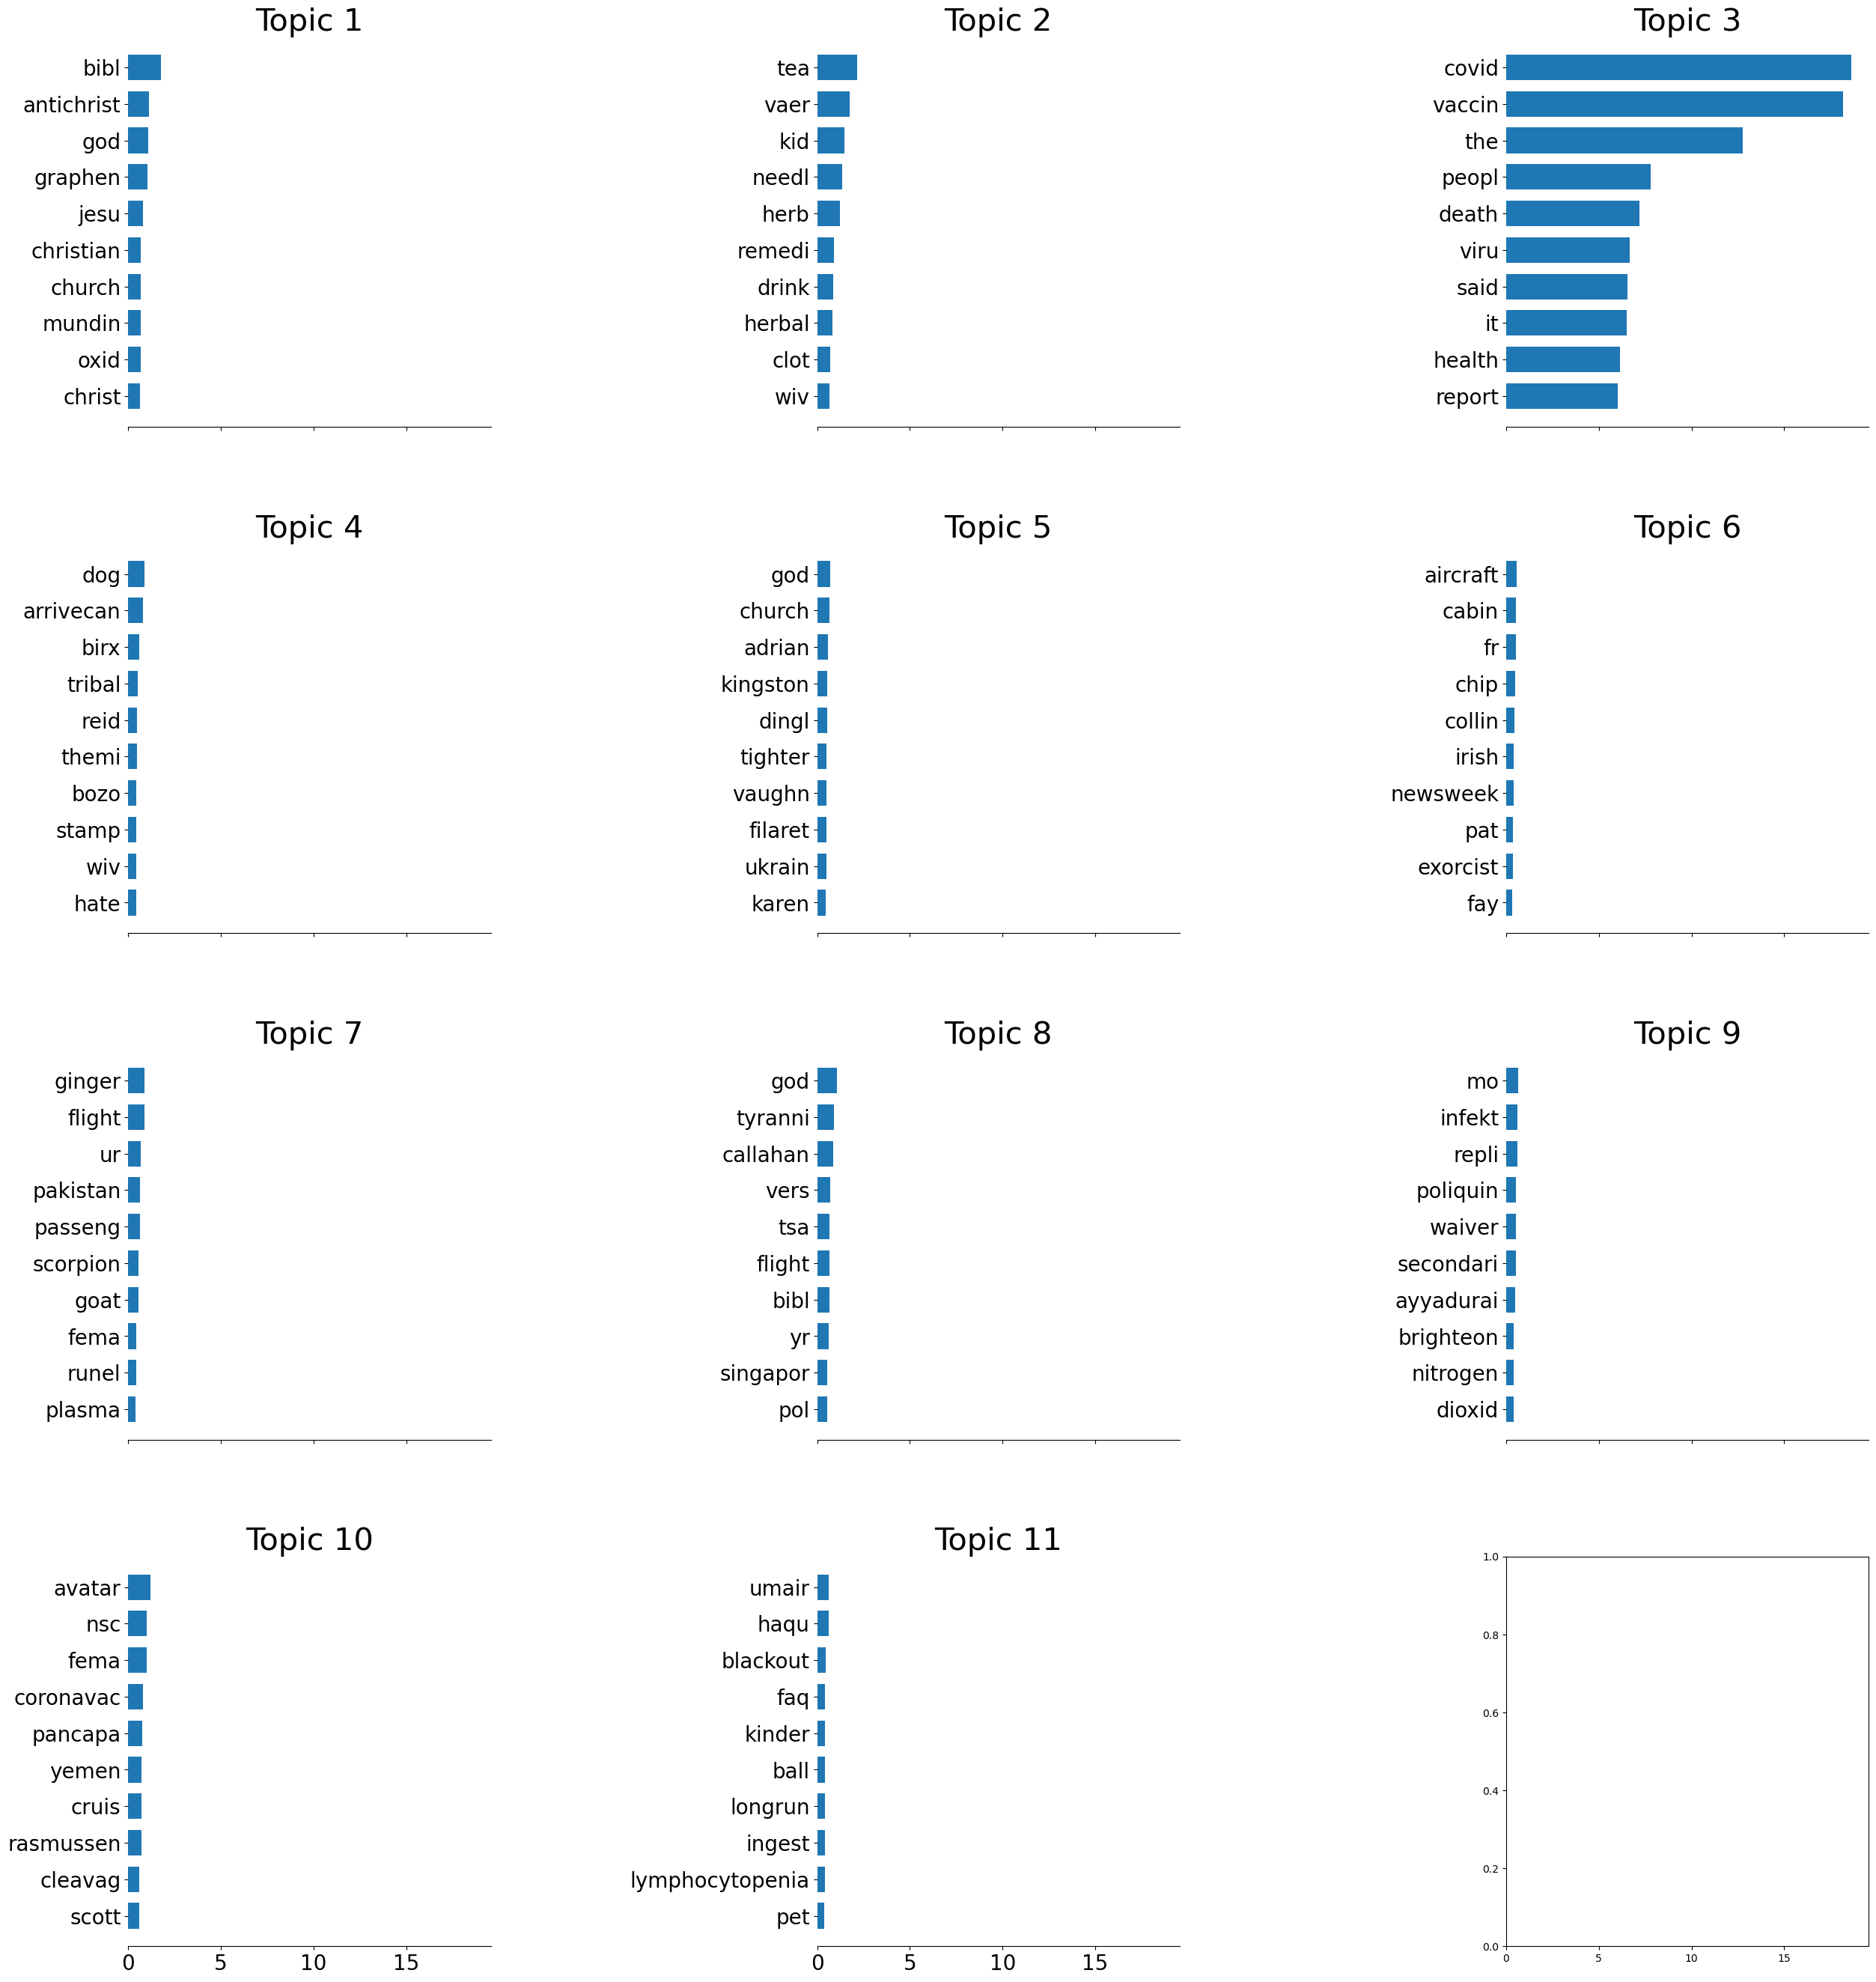

In [61]:
# Show the top words for each topic
n_top_words = 10
feature_names = content_tfidf_filtered.columns
plot_top_words(X_lda, feature_names, n_top_words, '')

##### Explanation:
Based on the charts, we found: 
1. Topic-2 is the most dominant one, which covers the general background and most popular topics around covid - almost like a COVID specific background. 
2. Topic-10: seem to related to disinformation that tried to falsely claim certain products can prevent covid. 
3. Topic-7 and Topic-9: posts related covid with bible. 
4. Topic-8: conspiracy theories around covid. 
5. Topic-3: cruise related/tsa

In [62]:
X_lda.components_.shape # count of topic * count of word

(11, 11388)

In [63]:
content_tfidf_filtered.shape # count of document * count of word

(237, 11388)

In [64]:
# create LDA score by document by topi
# use matrix multiplication: # count of doc * count of topic
lda_score_by_topic = pd.DataFrame(X_lda.components_.dot(content_tfidf_filtered.T).T) 

In [65]:
lst_n_cnt = list(range(1,n_cnt+1))
topic_n_cnt = ['topic_'+ str(i) for i in lst_n_cnt]

In [66]:
lda_score_by_topic.columns = topic_n_cnt

In [67]:
lda_score_by_topic

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
0,0.979576,0.958268,32.521565,1.002425,0.953790,0.953550,0.953554,0.965008,0.953552,0.953561,0.953555
1,1.103110,1.118697,22.985042,1.104173,1.249664,1.103022,1.115170,1.110286,1.103145,1.110245,1.107467
2,1.015753,1.016981,26.452432,1.015715,1.022161,1.015702,1.015711,1.180864,1.015706,1.015714,1.015704
3,0.782631,0.783884,19.075087,0.788939,0.788508,1.000708,0.782626,0.782629,0.782625,0.808674,0.782625
4,0.848311,0.852140,21.367058,0.848987,1.102630,0.848108,0.848111,0.880470,0.848118,0.848115,0.848153
...,...,...,...,...,...,...,...,...,...,...,...
232,1.238810,1.203163,16.469456,1.187715,1.201017,1.180033,1.237407,1.217359,1.177029,1.181057,1.281326
233,1.019167,1.070789,14.574406,0.915146,0.918356,0.911796,0.910897,1.389593,1.061823,1.235665,0.913211
234,1.186122,1.202117,26.440248,1.182298,1.182306,1.193445,1.182295,1.182306,1.182317,1.182303,1.186802
235,1.444443,1.525087,25.646980,1.446358,1.585945,1.438904,1.438998,1.458946,1.440658,1.442732,1.438907


In [68]:
# combine df data with topic weight
df_normalized = pd.concat([df, content_tfidf_filtered,lda_score_by_topic],axis =1)

In [69]:
# dummy variable for the log regression
df_normalized['y_misinfo_tag'] =  np.where(df_normalized['judgement_score']<=3,1,0)

In [70]:
# log-form len to make the numbers comparable with other metrics (divide by 10)
df_normalized['len_log'] = np.log10(df_normalized['len_org'])/10

In [71]:
df_normalized[['len_org','len_log']]

,len_org,len_log
0,6530,0.381491
1,32767,0.451544
2,4683,0.367052
3,1469,0.316702
4,3227,0.350880
...,...,...
232,8179,0.391270
233,10997,0.404127
234,6835,0.383474
235,7697,0.388632


In [72]:
# Uncomment the following line to output the dataframe to Excel, so that the entire contents can be seem more easily
# df_normalized.to_excel('df_normalized.xlsx')

### Data for logistic regression model
This code is adapted from two sources:
1. https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
2. https://www.geeksforgeeks.org/ml-logistic-regression-using-python/

In [73]:
# Prepare data for logistic regression modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [74]:
df_mdl_prep = df_normalized[['y_misinfo_tag',
                            'len_log',
                            'accuracy_score',
                            'sentiment_neg',
                            'sentiment_neu',
                            'sentiment_pos',
                            ]+topic_n_cnt]

In [75]:
# check if the dependent variable is balanced
df_mdl_prep['y_misinfo_tag'].value_counts()

1    122
0    115
Name: y_misinfo_tag, dtype: int64

In [76]:
df_mdl_prep.describe()

,y_misinfo_tag,len_log,accuracy_score,sentiment_neg,sentiment_neu,sentiment_pos,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,0.514768,0.366442,3.531646,0.078181,0.834924,0.086924,1.162881,1.223314,17.071018,1.087451,1.114948,1.061808,1.086231,1.143187,1.078820,1.116389,1.069590
std,0.500840,0.055444,1.091206,0.043630,0.060910,0.049255,0.469065,0.506309,6.767511,0.387624,0.401687,0.378659,0.372507,0.406894,0.391956,0.406546,0.378321
min,0.000000,0.178533,1.000000,0.000000,0.610000,0.000000,0.225845,0.225848,3.353898,0.225844,0.225845,0.225843,0.225846,0.225845,0.225844,0.225845,0.225845
25%,0.000000,0.349955,3.000000,0.047000,0.800000,0.057000,0.875998,0.890806,11.774271,0.855916,0.866120,0.848108,0.864307,0.880470,0.848118,0.864100,0.842328
50%,1.000000,0.374997,3.000000,0.073000,0.837000,0.081000,1.103887,1.159250,16.671714,1.066380,1.081445,1.056212,1.062815,1.122663,1.061896,1.086213,1.056213
75%,1.000000,0.402649,5.000000,0.107000,0.878000,0.110000,1.442944,1.537256,21.696075,1.313462,1.342604,1.283187,1.318942,1.421815,1.306465,1.326841,1.289867
max,1.000000,0.451544,5.000000,0.286000,1.000000,0.335000,2.744608,3.123383,35.112228,2.241440,2.408037,2.175022,2.175403,2.198365,2.303657,2.300481,2.174883


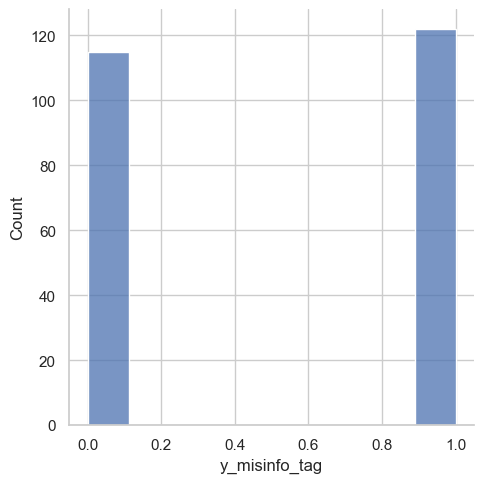

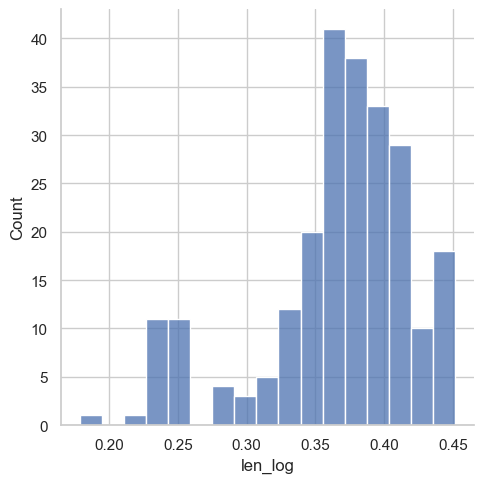

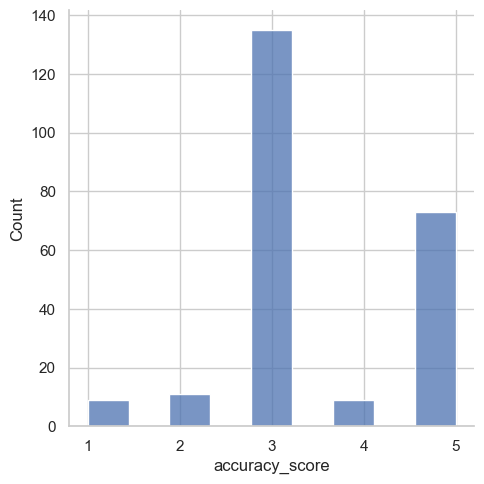

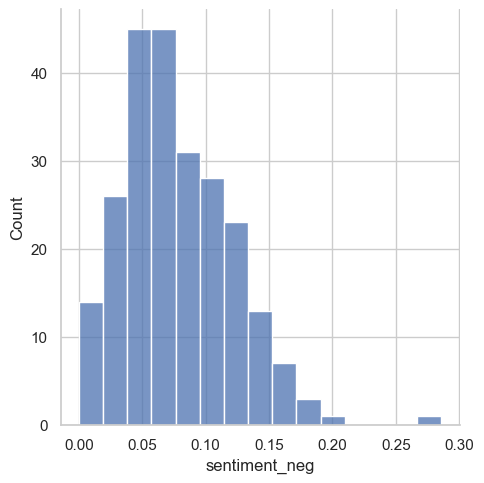

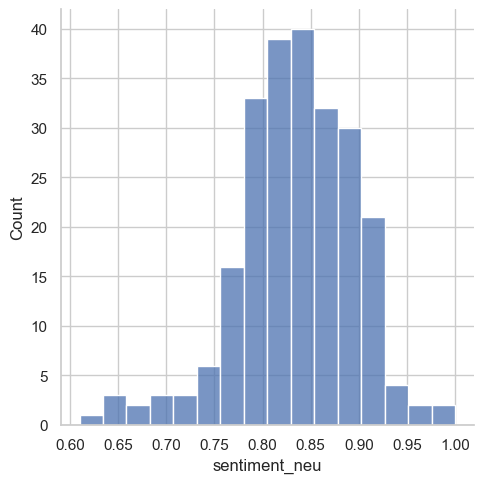

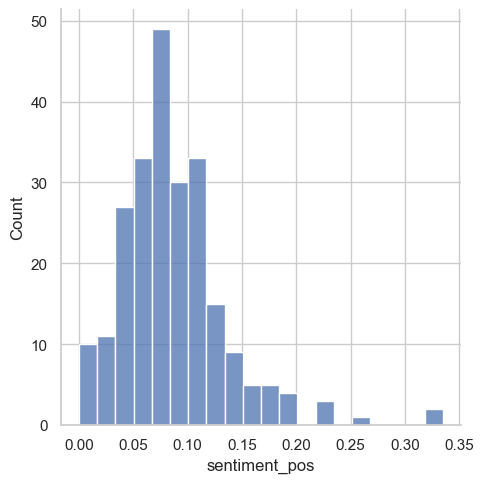

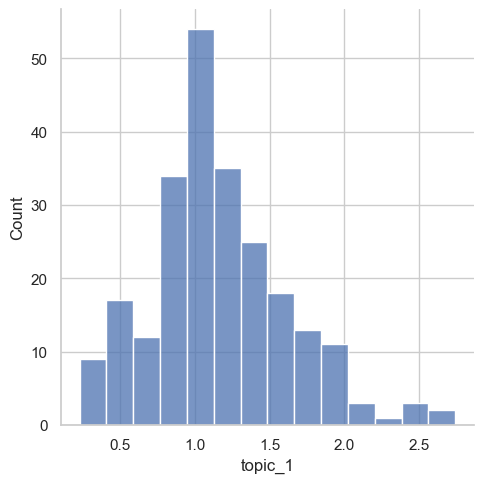

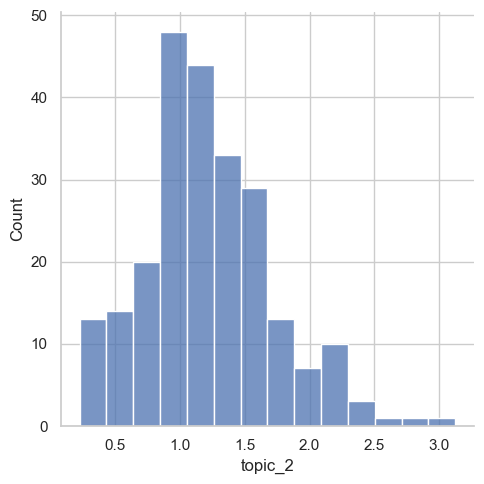

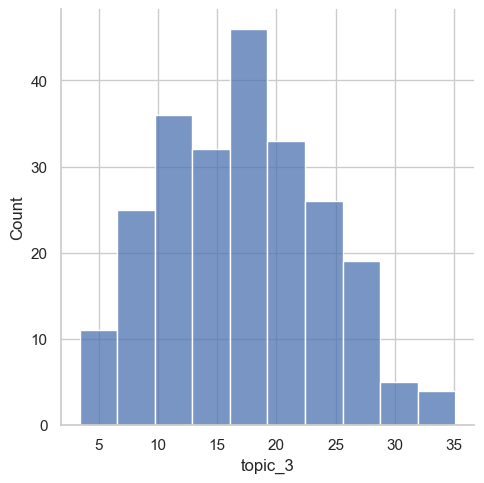

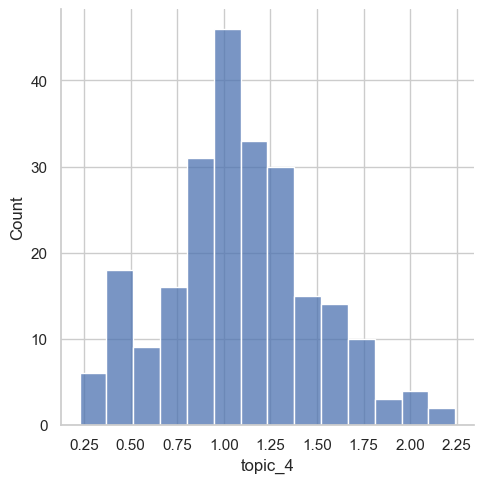

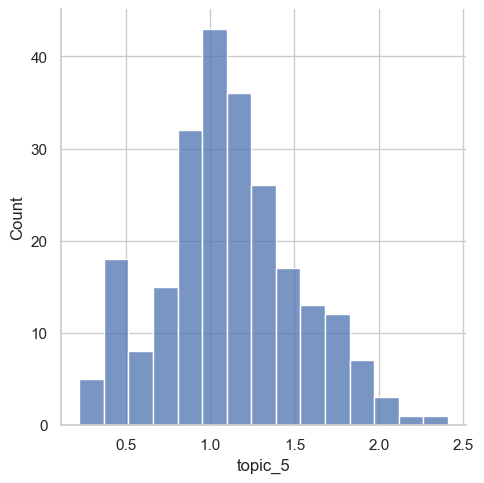

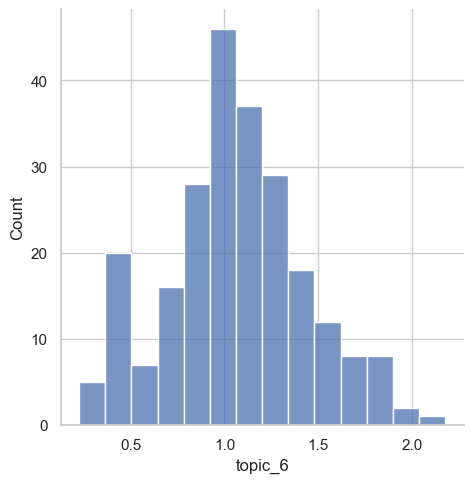

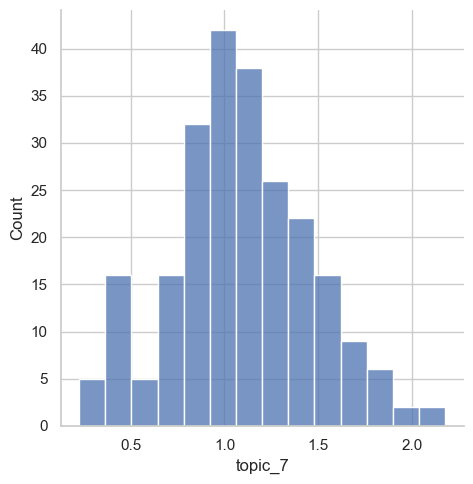

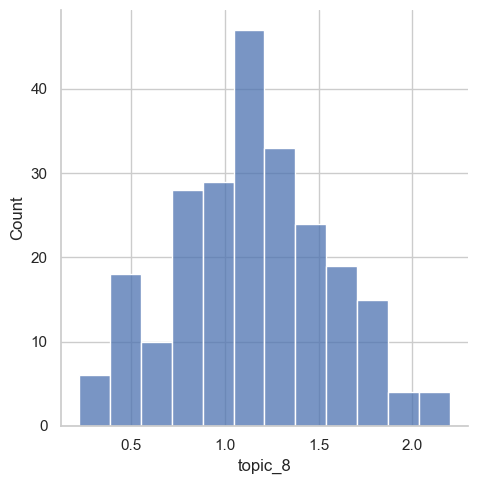

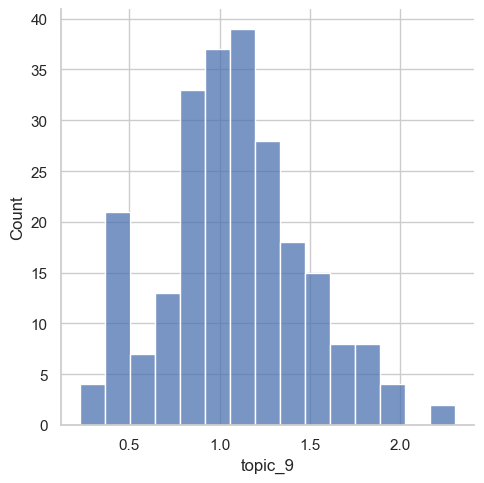

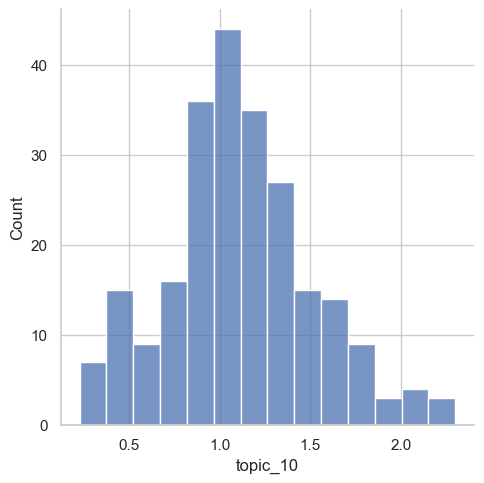

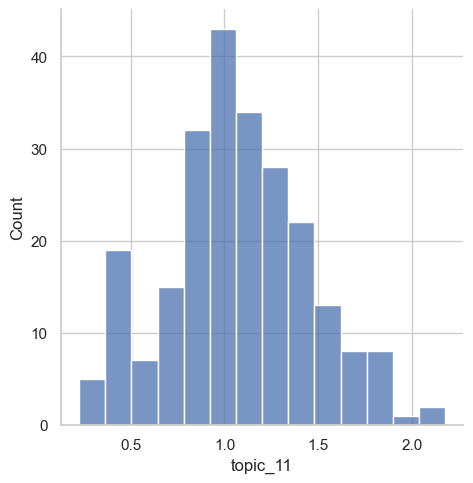

In [77]:
# generate data plots to check the skewness of the variables
for i in df_mdl_prep.columns:
    sns.displot(df_mdl_prep[i])

In [78]:
# use the 'original' data from covid_search_results_summary.xls as training data
y_train = df_mdl_prep.iloc[:org_len, 0].values
x_train = df_mdl_prep.iloc[:org_len, 1:len(df_mdl_prep)].values

# use the extra 1 inputs as testing data
# input
x_test = df_mdl_prep.iloc[org_len:org_len+1, 1:len(df_mdl_prep)].values

In [79]:
x_test

array([[ 0.25428254,  3.        ,  0.105     ,  0.895     ,  0.        ,
         0.44746079,  0.45669768, 10.91127578,  0.44754417,  0.44745986,
         0.44745773,  0.44745811,  0.44746261,  0.44745922,  0.63911941,
         0.44745855]])

In [80]:
# fit the logistic regression classifier to the training data set
classifier = LogisticRegression(random_state = 1)
classifier.fit(x_train, y_train)

LogisticRegression(random_state=1)

In [81]:
y_pred = float(classifier.predict_proba(x_test)[:,1][0]) # create the prediction as probability - for implementation
# y_pred = classifier.predict(x_test) # create the prediction as dummy - for optimization

In [82]:
# use probability to convert logistic regression output to 1-5 score for disinformation
if y_pred <=0.2:
    output_label = 1   # probably disinformation
elif y_pred <= 0.4:
    output_label = 2   # possibly disinformation
elif y_pred <= 0.6:
    output_label = 3   # 'neutral' mixture of disinfo and accurate info, or could not be determined
elif y_pred <= 0.8:
    output_label = 4   # possibly accurate (factual) information
else:
    output_label = 5   # probably accurate (factual) information
output_label

4

## Part III: Find the best values for the number of LDA clusters
### Please make sure to run Part II first to generate key files
Due to the limited time & a very small dataset, we will use brutal force (count of clusters from LDA), and sampling 10 different initalize values (LDA random_state) for each cluster count

In [83]:
from sklearn.metrics import precision_score 

In [84]:
#create list for count of LDA clusters
n_cnt_lst = list(range(5,17))
#n_cnt_lst = list(range(16,17))

In [85]:
#create list for random_state
random_state_lst = list(range(5,105,10))
#random_state_lst = list(range(55,65,10))
random_state_lst

[5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

In [86]:
algorithm_performance = []

In [87]:
# vary the number of topics to compare results
for n_cnt in n_cnt_lst:
    # vary the random_state value to see the effect on results
    for random_state_var in random_state_lst:
        try:
            lda = LatentDirichletAllocation(n_components=n_cnt,learning_decay=0.9,random_state=random_state_var)
            X_lda = lda.fit(content_tfidf_filtered)
            feature_names = content_tfidf_filtered.columns
            # plot_top_words(X_lda,feature_names,n_top_words,'')

            # create LDA score by document by topic
            lda_score_by_topic = pd.DataFrame(X_lda.components_.dot(content_tfidf_filtered.T).T)
            lst_n_cnt = list(range(1,n_cnt + 1))
            topic_n_cnt = ['topic_' + str(i) for i in lst_n_cnt]
            lda_score_by_topic.columns = topic_n_cnt
            df_normalized = pd.concat([df,content_tfidf_filtered,lda_score_by_topic],axis=1)

            #convert judgement score to dummy variable
            df_normalized['y_misinfo_tag'] = np.where(df_normalized['judgement_score'] <= 3,1,0)

            # log-form len to make the numbers comparable with other metrics (devide by 10)
            df_normalized['len_log'] = np.log10(df_normalized['len_org']) / 10
            df_mdl_prep = df_normalized[['y_misinfo_tag',
                                         'len_log',
                                         'accuracy_score',
                                         'sentiment_neg',
                                         'sentiment_neu',
                                         'sentiment_pos',
                                         ] + topic_n_cnt]

            from sklearn.linear_model import LogisticRegression
            y_train = df_mdl_prep.iloc[:org_len,0].values
            x_train = df_mdl_prep.iloc[:org_len,1:len(df_mdl_prep)].values

            classifier = LogisticRegression(random_state=1)
            classifier.fit(x_train,y_train)

            y_pred_org = classifier.predict(x_train)
            precision_score(y_train, y_pred_org)
            algorithm_performance.append((n_cnt,random_state_var,precision_score(y_train, y_pred_org)))
            print('cluster_cnt = {}, rand state = {}, precision_score = {}'.format(n_cnt,random_state_var,precision_score(y_train, y_pred_org)))
        except:
            print('cluster_cnt = {}, rand state = {}, precision_score = no result'.format(n_cnt,random_state_var))


cluster_cnt = 5, rand state = 5, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 15, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 25, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 35, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 45, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 55, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 65, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 75, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 85, precision_score = 0.8235294117647058
cluster_cnt = 5, rand state = 95, precision_score = 0.8235294117647058
cluster_cnt = 6, rand state = 5, precision_score = 0.8175182481751825
cluster_cnt = 6, rand state = 15, precision_score = 0.8175182481751825
cluster_cnt = 6, rand state = 25, precision_score = 0.8235294117647058
cluster_cnt = 6, rand state = 35, precision_score = 0.8235294117647058
cluster_

cluster_cnt = 16, rand state = 55, precision_score = 0.8115942028985508
cluster_cnt = 16, rand state = 65, precision_score = 0.8432835820895522
cluster_cnt = 16, rand state = 75, precision_score = 0.8175182481751825
cluster_cnt = 16, rand state = 85, precision_score = 0.8161764705882353
cluster_cnt = 16, rand state = 95, precision_score = 0.8296296296296296


In [88]:
cols = ['LDA_CLUSTER_COUNT','RAND_STATE','PRECISION_SCORE']

In [89]:
algorithm_performance_df = pd.DataFrame(algorithm_performance, columns=cols)

In [90]:
algorithm_performance_df.groupby('LDA_CLUSTER_COUNT').mean()

,RAND_STATE,PRECISION_SCORE
LDA_CLUSTER_COUNT,,
5,50.0,0.823529
6,50.0,0.819931
7,50.0,0.820541
8,50.0,0.818480
9,50.0,0.825147
10,50.0,0.819255
11,50.0,0.824669
12,50.0,0.820686
13,50.0,0.832529


In [91]:
algorithm_performance_chrt = algorithm_performance_df.groupby('LDA_CLUSTER_COUNT').mean()

<AxesSubplot:xlabel='LDA_CLUSTER_COUNT', ylabel='PRECISION_SCORE'>

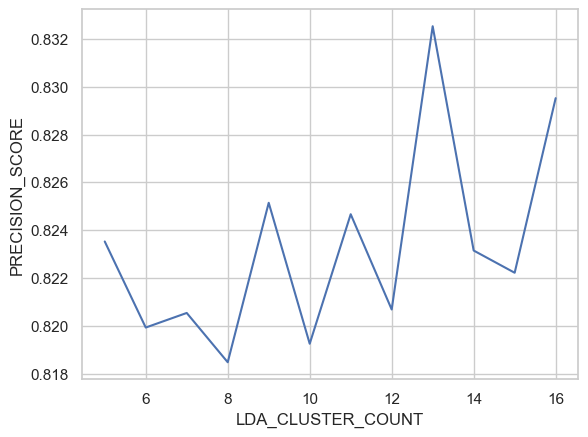

In [92]:
# From this chart we can find the optimal number of topics, based on maximizing precision_score
import seaborn as sns
sns.lineplot(x= 'LDA_CLUSTER_COUNT', y= 'PRECISION_SCORE', data= algorithm_performance_chrt)

##### Explanation:
With more than 11 clusters there is not a lot of improvement. The 'original' dataset appears to be too small for the task (cases where fail to converge)